<a href="https://colab.research.google.com/github/liuxx479/NGphotoz/blob/master/prep_mass_production.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [38]:
import numpy as np
from matplotlib import pyplot as plt
from pylab import *
from scipy.stats import norm
from scipy.stats import uniform
from astropy.io import fits
from astropy import units as u
import os
sys.modules["mpi4py"] = None
from lenstools import ConvergenceMap
from IPython.display import Image
%matplotlib inline

### goals of this notebook
##### 1) compute the nubmer density per z bin, using the fiducial photo-z (sigma_z=0, or step function was used)
##### 2) add noise as GRF to each redshift
##### 3) smooth the maps
##### 4) define the bin edges
##### 5) compute peaks, minima, PDF, MFs, moments
##### 6) turn this into a python code

In [86]:
!git add prep_map_stats.ipynb; git commit -m 'update prep_map.stats; smooth the map'; git push

[master 9fcb328] update prep_map.stats; smooth the map
 1 file changed, 9 insertions(+), 11 deletions(-)
Counting objects: 3, done.
Delta compression using up to 64 threads.
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 520 bytes | 520.00 KiB/s, done.
Total 3 (delta 2), reused 0 (delta 0)
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To ssh://github.com/liuxx479/NGphotoz.git
   8a8b523..9fcb328  master -> master


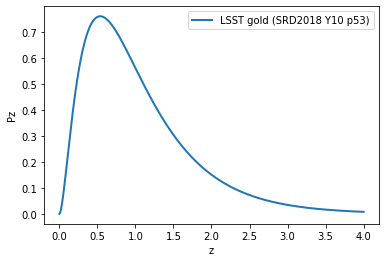

In [2]:
##### number density per redshift bins
def Pz_norm(zp_support, pz):
  return pz/np.trapz(pz, zp_support)

def Pz_norm_tomo(zp_support, pz):
  return array([Pz_norm(zp_support, ipz) for ipz in pz])

zarr=np.linspace(0,4, 501)
delta_z=0.5

tomo_centers=np.arange(0.5, 3, delta_z)
tomo_widths=np.ones(5)*delta_z
tomo_edges = np.array([tomo_centers-delta_z/2, tomo_centers+delta_z/2]).T

z0_SRD, alpha_SRD = 0.11, 0.68
Pz_SRD_unnorm = lambda z: z**2 * exp(-(z/z0_SRD)**alpha_SRD)
Pz_SRD_norm = lambda z: Pz_norm(z, Pz_SRD_unnorm(z))

plot(zarr, Pz_SRD_norm(zarr), lw=2, label='LSST gold (SRD2018 Y10 p53)')
xlabel('z')
ylabel('Pz')
legend()
show()

In [4]:
############ fiducial model: pz_true.txt 
### zbias=0, sigma_z=0, outlier=0; it should have sharp cut off at the bin edges ([0.25, 0.75], [0.75, 1.25]...)
####### LSST SRD Y10 numbers page 53
######## SRD: https://arxiv.org/abs/1809.01669
## neff: (z0, α) = (0.13, 0.78) for Y1 and (0.11, 0.68) for Y10
## neff = 10 and 27 arcmin−2 as the lensing neff in Y1 and Y10
## however, according to the original Chang 2013 paper, unmasked neff=37
sigma_e = 0.26 ## per component, do I need a sqrt(2) to get both components? (I didn't do this in 2014..)
neff = 37 ## chang+2013 n=46, for fiducial case
ngal = 46

### 1) compute the nubmer density per z bin

In [5]:
ngal_tomo = np.zeros(5)
Pz_norm_factor = np.trapz(Pz_SRD_unnorm(zarr),zarr)
print (Pz_norm_factor)

for i in range(5):
    iz0,iz1=tomo_edges[i]
    izarr=zarr[where((zarr>iz0)&(zarr<iz1))]
    ngal_tomo[i]= ngal * np.trapz(Pz_SRD_unnorm(izarr), izarr) / Pz_norm_factor

0.020049679068572506


In [10]:
print ('number of galaxies per redshift bin \n(ngal=%i, %s galaxies in 5 bins):'%(ngal, sum(ngal_tomo)))
for i in range(5):
    print ('z=%s, ngal=%.2f /arcmin^2'%(tomo_edges[i], ngal_tomo[i]))

number of galaxies per redshift bin 
(ngal=46, 40.99631314209885 galaxies in 5 bins):
z=[0.25 0.75], ngal=16.07 /arcmin^2
z=[0.75 1.25], ngal=12.82 /arcmin^2
z=[1.25 1.75], ngal=6.93 /arcmin^2
z=[1.75 2.25], ngal=3.51 /arcmin^2
z=[2.25 2.75], ngal=1.66 /arcmin^2


### 2) add noise as GRF to each redshift

In [11]:
###### get a set of 5 test maps
test_dir = '/global/cscratch1/sd/jialiu/desc-sprint-raytracing/Cosmo_maps/06_f/'
os.listdir(test_dir)[:10]
fnames = [test_dir+'kappa_LSST-SRD_tomo%i_cone5.fits'%(i) for i in range(1,6)]
test_maps = array([fits.open(ifn)[0].data for ifn in fnames])
istds = [std(it) for it in test_maps]
print (istds)

[0.007314169, 0.019146424, 0.031151935, 0.041499652, 0.050280314]


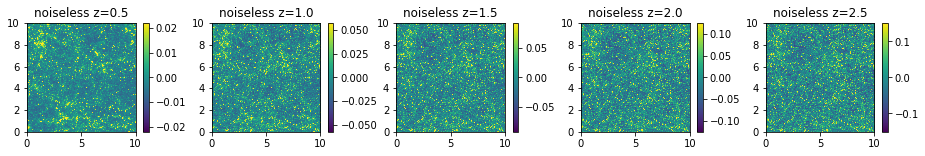

In [23]:
#### plot original kappa maps
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds[i]
    imshow(test_maps[i], vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('noiseless z=%.1f'%(tomo_centers[i]))
    colorbar()

In [14]:
### white noise maps for shape noise
map_side_deg = 10*u.degree
pixel_angular_side = map_side_deg / test_maps[0].shape[0]

sigma_pix_arr =[ (sigma_e / (pixel_angular_side * sqrt(ingal / u.arcmin**2))).decompose().value
                for ingal in ngal_tomo]

print (map_side_deg, test_maps[0].shape[0])
print (pixel_angular_side.to (u.arcmin))
print (sigma_pix_arr)

np.random.seed(2)
noise_maps = [np.random.normal(loc=0.0, scale=sigma_pix_arr[i], size=test_maps[0].shape) 
              for i in range(5)]

# #Generate shape noise
#sigma = ((0.15 + 0.035*z) / (pixel_angular_side * np.sqrt(ngal))).decompose().value
# np.random.seed(seed)
# noise_map = np.random.normal(loc=0.0,scale=sigma,size=self.shape) 

10.0 deg 7745
0.0774693350548741 arcmin
[0.8373384105463355, 0.9372762624156529, 1.274722171595974, 1.7907843269067931, 2.6010219215711436]


In [100]:
## turn it into convergencemap instance
conv_noiseless_maps = [ConvergenceMap(data=test_maps[i], angle=map_side_deg) for i in range(5)]
conv_maps = [ConvergenceMap(data=test_maps[i]+noise_maps[i], angle=map_side_deg) for i in range(5)]

In [26]:
istds_noisy = [conv_maps[i].std() for i in range(5)]
print (istds_noisy)

[0.8372021544930138, 0.9374195324734388, 1.275025662475702, 1.7912769418845758, 2.6011430478816924]


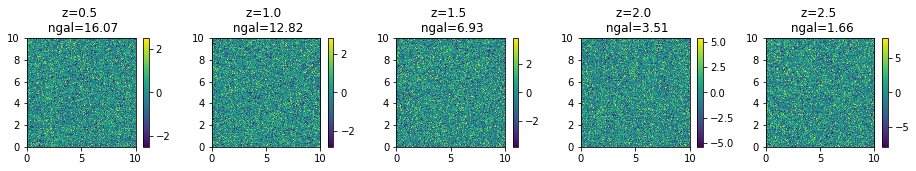

In [34]:
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds_noisy[i]
    imshow(conv_maps[i].data, vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('z=%.1f \n ngal=%.2f'%(tomo_centers[i], ngal_tomo[i]))
    colorbar()

### 3) smooth the maps

In [110]:
theta_g = 5 #arcmin
smoothed_conv_maps= [conv_maps[i].smooth(theta_g*u.arcmin) for i in range(5)]

In [111]:
istds_smoothed = [smoothed_conv_maps[i].std() for i in range(5)]
print (istds_smoothed)

[0.005241955736210872, 0.008564711876178181, 0.012418808999851485, 0.015938081939761237, 0.019748459683218072]


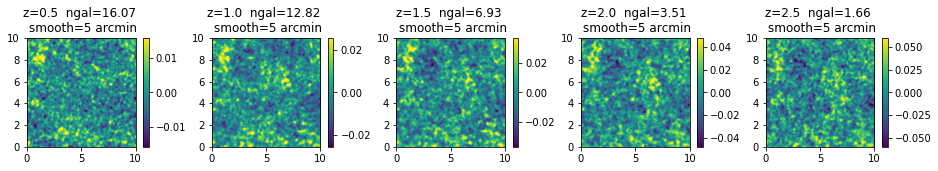

In [113]:
figure(figsize=(16,2))
for i in range(5):
    subplot(1,5,i+1)
    istd=istds_smoothed[i]
    imshow(smoothed_conv_maps[i].data, vmin=-3*istd, vmax=3*istd, origin='lower', extent=[0,10,0,10])
    title('z=%.1f  ngal=%.2f \n smooth=%s arcmin'%(tomo_centers[i], ngal_tomo[i], theta_g))
    colorbar()

### 4) define the bin edges
<img src="theory_noise_smoothed.jpg" width="400">

In [114]:
######### the std of noise maps
istds_noise_smoothed = array([ConvergenceMap(data=noise_maps[i], 
                                             angle=map_side_deg).smooth(theta_g*u.arcmin,mode='wrap').std() 
                            for i in range(5)])

In [116]:
# this is from Coulton2019, not sure where is the log(2) factor from
# const_n = 1/sqrt(4*log(2)*pi)#0.3388303758015525 

# this matches yang2011, with their 1 arcmin = my/usual 1/sqrt(2) arcmin, and seem correct
const_n = 1/sqrt(4*pi)

## theta_g in unit of 1 arcmin, ngal in unit of 1/armin^2
sigma_smooth = lambda ngal, theta_g: const_n* sigma_e/(theta_g * sqrt(ngal))
sigma_n_theory = sigma_smooth (array(ngal_tomo), theta_g)

print ('std for smoothed noisy maps:')
print (sigma_n_theory, 'theory')
print (istds_noise_smoothed, 'sim')
print (sigma_n_theory/istds_noise_smoothed, 'theory/sim')

std for smoothed noisy maps:
[0.00365979 0.00409659 0.00557148 0.00782705 0.01136839] theory
[0.00367996 0.0041307  0.00571327 0.00767741 0.01108711] sim
[0.99451827 0.99174296 0.97518189 1.01949161 1.0253702 ] theory/sim


In [117]:
sigma_bin_edges = linspace(-5,5,21)
print ('bin edges (sigma):\n',sigma_bin_edges)

kappa_bin_edges = kron(sigma_n_theory,sigma_bin_edges).reshape(5,-1)
print ('bin edges (kappa):\n', kappa_bin_edges)

bin edges (sigma):
 [-5.  -4.5 -4.  -3.5 -3.  -2.5 -2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5
  2.   2.5  3.   3.5  4.   4.5  5. ]
bin edges (kappa):
 [[-0.01829894 -0.01646905 -0.01463915 -0.01280926 -0.01097936 -0.00914947
  -0.00731958 -0.00548968 -0.00365979 -0.00182989  0.          0.00182989
   0.00365979  0.00548968  0.00731958  0.00914947  0.01097936  0.01280926
   0.01463915  0.01646905  0.01829894]
 [-0.02048295 -0.01843466 -0.01638636 -0.01433807 -0.01228977 -0.01024148
  -0.00819318 -0.00614489 -0.00409659 -0.0020483   0.          0.0020483
   0.00409659  0.00614489  0.00819318  0.01024148  0.01228977  0.01433807
   0.01638636  0.01843466  0.02048295]
 [-0.02785739 -0.02507165 -0.02228591 -0.01950017 -0.01671443 -0.0139287
  -0.01114296 -0.00835722 -0.00557148 -0.00278574  0.          0.00278574
   0.00557148  0.00835722  0.01114296  0.0139287   0.01671443  0.01950017
   0.02228591  0.02507165  0.02785739]
 [-0.03913526 -0.03522173 -0.0313082  -0.02739468 -0.02348115 -0.019567

### 5) compute peaks, minima, PDF, MFs, moments

In [121]:
peaks_test = [smoothed_conv_maps[i].peakCount(kappa_bin_edges[i]) for i in range(5)]

In [126]:
pdf_test = [smoothed_conv_maps[i].pdf(kappa_bin_edges[i]) for i in range(5)]

In [124]:
minima_test = [ConvergenceMap(data=-smoothed_conv_maps[i].data, 
                              angle=map_side_deg).peakCount(kappa_bin_edges[i]) for i in range(5)]

In [127]:
mf_test = [smoothed_conv_maps[i].minkowskiFunctionals(kappa_bin_edges[i]) for i in range(5)]

In [129]:
#moments_test = [smoothed_conv_maps[i].moments(kappa_bin_edges[i]) for i in range(5)]

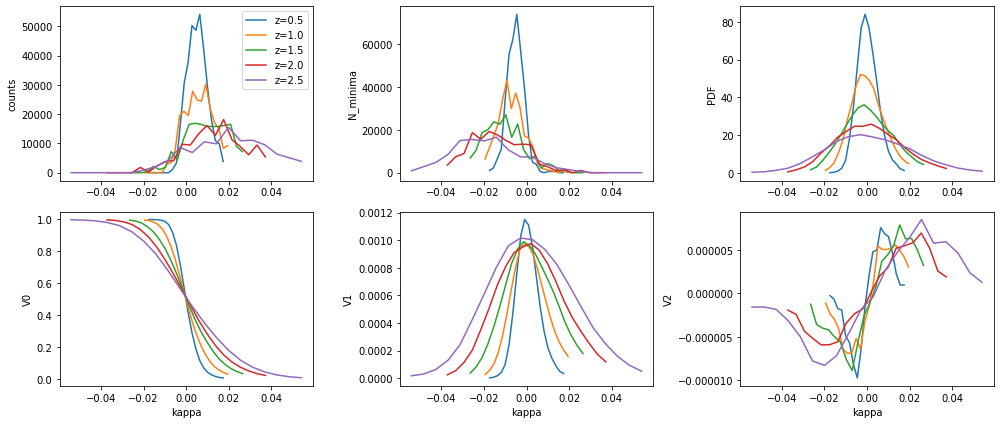

In [150]:
f,axes=subplots(2,3,figsize=(14,6))
for i in range(5):
    axes[0][0].plot(peaks_test[i][0], peaks_test[i][1], label='z=%s'%(tomo_centers[i]))
    axes[0][1].plot(minima_test[i][0], minima_test[i][1][::-1])## note need to flip the axis
    axes[0][2].plot(pdf_test[i][0], pdf_test[i][1])
    axes[1][0].plot(mf_test[i][0],mf_test[i][1])
    axes[1][1].plot(mf_test[i][0],mf_test[i][2])
    axes[1][2].plot(mf_test[i][0],mf_test[i][3])
axes[0][0].legend()
axes[1][0].set_xlabel('kappa')
axes[1][1].set_xlabel('kappa')
axes[1][2].set_xlabel('kappa')
axes[0][0].set_ylabel('N_peaks')
axes[0][1].set_ylabel('N_minima')
axes[0][2].set_ylabel('PDF')
axes[0][0].set_ylabel('counts')
axes[1][0].set_ylabel('V0')
axes[1][1].set_ylabel('V1')
axes[1][2].set_ylabel('V2')
plt.tight_layout()